In [199]:
# File Imports
import pandas as pd
from pathlib import Path

from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans, AgglomerativeClustering, Birch
from sklearn.decomposition import PCA


In [200]:
# Import the data:
file_location = "./resources/data_science_salaries.csv"
file_path = Path(file_location)

salary_df = pd.read_csv(file_path)
# Display the DataFrame:
salary_df.head()

job_title experience_level employment_type work_models  work_year  \
0   Data Engineer        Mid-level       Full-time      Remote       2024   
1   Data Engineer        Mid-level       Full-time      Remote       2024   
2  Data Scientist     Senior-level       Full-time      Remote       2024   
3  Data Scientist     Senior-level       Full-time      Remote       2024   
4    BI Developer        Mid-level       Full-time     On-site       2024   

  employee_residence  salary salary_currency  salary_in_usd company_location  \
0      United States  148100             USD         148100    United States   
1      United States   98700             USD          98700    United States   
2      United States  140032             USD         140032    United States   
3      United States  100022             USD         100022    United States   
4      United States  120000             USD         120000    United States   

  company_size  
0       Medium  
1       Medium  
2       Medium  
3       Medium  
4       Medium

# Prepare the Data 

In [201]:
# Drop the irrelevant columns, salary and salary currency
salary_df = salary_df.drop(columns=['salary', 'salary_currency', 'work_year'])
salary_df.head()

job_title experience_level employment_type work_models  \
0   Data Engineer        Mid-level       Full-time      Remote   
1   Data Engineer        Mid-level       Full-time      Remote   
2  Data Scientist     Senior-level       Full-time      Remote   
3  Data Scientist     Senior-level       Full-time      Remote   
4    BI Developer        Mid-level       Full-time     On-site   

  employee_residence  salary_in_usd company_location company_size  
0      United States         148100    United States       Medium  
1      United States          98700    United States       Medium  
2      United States         140032    United States       Medium  
3      United States         100022    United States       Medium  
4      United States         120000    United States       Medium

In [202]:
salary_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6599 entries, 0 to 6598
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   job_title           6599 non-null   object
 1   experience_level    6599 non-null   object
 2   employment_type     6599 non-null   object
 3   work_models         6599 non-null   object
 4   employee_residence  6599 non-null   object
 5   salary_in_usd       6599 non-null   int64 
 6   company_location    6599 non-null   object
 7   company_size        6599 non-null   object
dtypes: int64(1), object(7)
memory usage: 412.6+ KB


In [203]:
# Find the quartiles, IQR and outlier bounds
salaries = salary_df["salary_in_usd"]
Q1 = salaries.quantile(0.25)
median = salaries.quantile(0.5)
Q3 = salaries.quantile(0.75)
IQR = Q3 - Q1

print(f"The lower quartile of salary is: {Q1}")
print(f"The upper quartile of salary is: {Q3}")
print(f"The interquartile range of salary is: {IQR}")
print(f"The the median of salary is: {median} ")

lower_bound = Q1 - (1.5 * IQR)
upper_bound = Q3 + (1.5 * IQR)
print(f"Values below {lower_bound} could be outliers.")
print(f"Values above {upper_bound} could be outliers.")

The lower quartile of salary is: 95000.0
The upper quartile of salary is: 185000.0
The interquartile range of salary is: 90000.0
The the median of salary is: 138666.0 
Values below -40000.0 could be outliers.
Values above 320000.0 could be outliers.


In [204]:
# Exclude the outliers 
salary_df = salary_df.loc[salary_df['salary_in_usd'] <= upper_bound]
salary_df = salary_df.reset_index(drop=True)
salary_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6492 entries, 0 to 6491
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   job_title           6492 non-null   object
 1   experience_level    6492 non-null   object
 2   employment_type     6492 non-null   object
 3   work_models         6492 non-null   object
 4   employee_residence  6492 non-null   object
 5   salary_in_usd       6492 non-null   int64 
 6   company_location    6492 non-null   object
 7   company_size        6492 non-null   object
dtypes: int64(1), object(7)
memory usage: 405.9+ KB


## Encode Categorical Columns
Use Frequency encoder for columns with high cardinality.  Use Pandas get_dummies for columns with low cardinality

In [205]:
# Check cardinality of columns
salary_df.nunique()

job_title              130
experience_level         4
employment_type          4
work_models              3
employee_residence      86
salary_in_usd         2090
company_location        75
company_size             3
dtype: int64

In [206]:
# Frequency encoder
freq_features = ['job_title', 'employee_residence', 'company_location']
# freq_features = ['job_title', 'employee_residence', 'company_location', 'experience_level', 'employment_type', 'work_models', 'company_size']

encoded_df = salary_df.copy()
encoded_mappings = {} 

for col in freq_features:
    frequencies = salary_df[col].value_counts(normalize=True) # Calculate frequencies
    encoded_mappings[col] = frequencies.to_dict() # Store mapping

    encoded_df[col + '_freq'] = salary_df[col].map(frequencies) # Create new freq column
    encoded_df.drop(col, axis=1, inplace=True) # Drop original column (Optional)

print("Frequency Encoding Mappings:")
for col, mapping in encoded_mappings.items():
    print(f"Column '{col}': {mapping}")

Frequency Encoding Mappings:
Column 'job_title': {'Data Engineer': 0.19963031423290203, 'Data Scientist': 0.1899260628465804, 'Data Analyst': 0.13971041281577326, 'Machine Learning Engineer': 0.09426987060998152, 'Analytics Engineer': 0.03727664818237831, 'Research Scientist': 0.030345040049291436, 'Data Architect': 0.02649414664202095, 'Research Engineer': 0.019870609981515713, 'ML Engineer': 0.016173752310536044, 'Applied Scientist': 0.01463339494762785, 'Data Science Manager': 0.013093037584719655, 'Business Intelligence Analyst': 0.012630930375847197, 'Machine Learning Scientist': 0.010782501540357363, 'Business Intelligence Engineer': 0.010628465804066543, 'Data Manager': 0.009704251386321626, 'Research Analyst': 0.009242144177449169, 'Data Science': 0.008471965495995071, 'Data Specialist': 0.007239679605668515, 'AI Engineer': 0.006777572396796057, 'Data Science Consultant': 0.006469500924214418, 'BI Developer': 0.006315465187923599, 'Machine Learning Infrastructure Engineer': 0.0

In [207]:
# Use Pandas one-hot encoder, get_dummies, for the columns with low cardinality

nominal_features = ['experience_level', 'employment_type', 'work_models', 'company_size']
encoded_df = pd.get_dummies(encoded_df, columns=nominal_features, drop_first=True, dtype=int)
encoded_df.head()

salary_in_usd  job_title_freq  employee_residence_freq  \
0         148100        0.199630                  0.80191   
1          98700        0.199630                  0.80191   
2         140032        0.189926                  0.80191   
3         100022        0.189926                  0.80191   
4         120000        0.006315                  0.80191   

   company_location_freq  experience_level_Executive-level  \
0               0.809304                                 0   
1               0.809304                                 0   
2               0.809304                                 0   
3               0.809304                                 0   
4               0.809304                                 0   

   experience_level_Mid-level  experience_level_Senior-level  \
0                           1                              0   
1                           1                              0   
2                           0                              1   
3                           0                              1   
4                           1                              0   

   employment_type_Freelance  employment_type_Full-time  \
0                          0                          1   
1                          0                          1   
2                          0                          1   
3                          0                          1   
4                          0                          1   

   employment_type_Part-time  work_models_On-site  work_models_Remote  \
0                          0                    0                   1   
1                          0                    0                   1   
2                          0                    0                   1   
3                          0                    0                   1   
4                          0                    1                   0   

   company_size_Medium  company_size_Small  
0                    1                   0  
1                    1                   0  
2                    1                   0  
3                    1                   0  
4                    1                   0

## Scale the salary_in_usd column

In [208]:
# Use Standard Scaler to scale the salary_in_usd column
scaled_data = StandardScaler().fit_transform(encoded_df[['salary_in_usd']])
scaled_data[0:5]

array([[ 0.10633315],
       [-0.68580885],
       [-0.02303935],
       [-0.66461024],
       [-0.34425775]])

In [209]:
# Create a DataFrame of the scaled data
scaled_df = pd.DataFrame(scaled_data, columns=['salary_in_usd'])

# Copy the encoded data frame to cleaned_df, and update the scaled salary_in_usd
cleaned_df = encoded_df.copy()
cleaned_df['salary_in_usd'] = scaled_df['salary_in_usd']

cleaned_df.head()

salary_in_usd  job_title_freq  employee_residence_freq  \
0       0.106333        0.199630                  0.80191   
1      -0.685809        0.199630                  0.80191   
2      -0.023039        0.189926                  0.80191   
3      -0.664610        0.189926                  0.80191   
4      -0.344258        0.006315                  0.80191   

   company_location_freq  experience_level_Executive-level  \
0               0.809304                                 0   
1               0.809304                                 0   
2               0.809304                                 0   
3               0.809304                                 0   
4               0.809304                                 0   

   experience_level_Mid-level  experience_level_Senior-level  \
0                           1                              0   
1                           1                              0   
2                           0                              1   
3                           0                              1   
4                           1                              0   

   employment_type_Freelance  employment_type_Full-time  \
0                          0                          1   
1                          0                          1   
2                          0                          1   
3                          0                          1   
4                          0                          1   

   employment_type_Part-time  work_models_On-site  work_models_Remote  \
0                          0                    0                   1   
1                          0                    0                   1   
2                          0                    0                   1   
3                          0                    0                   1   
4                          0                    1                   0   

   company_size_Medium  company_size_Small  
0                    1                   0  
1                    1                   0  
2                    1                   0  
3                    1                   0  
4                    1                   0

In [210]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6492 entries, 0 to 6491
Data columns (total 14 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   salary_in_usd                     6492 non-null   float64
 1   job_title_freq                    6492 non-null   float64
 2   employee_residence_freq           6492 non-null   float64
 3   company_location_freq             6492 non-null   float64
 4   experience_level_Executive-level  6492 non-null   int32  
 5   experience_level_Mid-level        6492 non-null   int32  
 6   experience_level_Senior-level     6492 non-null   int32  
 7   employment_type_Freelance         6492 non-null   int32  
 8   employment_type_Full-time         6492 non-null   int32  
 9   employment_type_Part-time         6492 non-null   int32  
 10  work_models_On-site               6492 non-null   int32  
 11  work_models_Remote                6492 non-null   int32  
 12  compan

# Unsupervised ML Analysis

## Use the KMeans Elbow Method to Find the Best Number of clusters

In [211]:
# Create a a list to store inertia values and the values of k
inertia = []
k = list(range(1, 11))

# Create a for-loop where each value of k is evaluated using the K-means algorithm
# Fit the model using the service_ratings DataFrame
# Append the value of the computed inertia from the `inertia_` attribute of the KMeans model instance
for i in k:
    k_model = KMeans(n_clusters=i, n_init='auto', random_state=10)
    k_model.fit(cleaned_df)
    inertia.append(k_model.inertia_)

# Define a DataFrame to hold the values for k and the corresponding inertia
elbow_data = {'k' : k, 'inertia': inertia}
elbow_df = pd.DataFrame(elbow_data)

# Review the DataFrame
elbow_df

k       inertia
0   1  14768.631331
1   2  10073.432839
2   3   8433.806791
3   4   6843.016806
4   5   6125.955042
5   6   5253.066548
6   7   4925.634630
7   8   4375.997518
8   9   4142.818185
9  10   3991.949675

<Axes: title={'center': 'Elbow Curve'}, xlabel='k'>

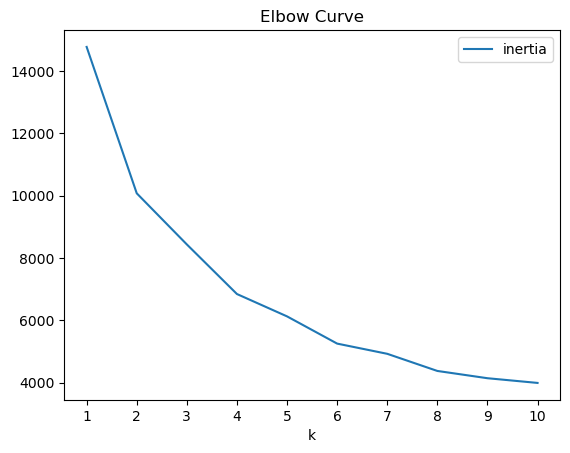

In [212]:
# Plot a line chart with all the inertia values computed with 
# the different values of k to visually identify the optimal value for k.
elbow_df.plot.line(x='k',
                   y='inertia',
                   title="Elbow Curve", 
                   xticks = k)

### Use K-means to cluster data with the best k value

In [213]:
# Initialize the K-Means model using the best value for k
k_model = KMeans(n_clusters=4, n_init='auto', random_state=10)

# Fit the K-Means model using the scaled data
k_model.fit(cleaned_df)

# Predict the clusters to group the cryptocurrencies using the scaled data
k_predictions = k_model.predict(cleaned_df)

# Create a copy of the preprocessed data
salary_predictions_df = cleaned_df.copy()

# Add a class column with the labels
salary_predictions_df['kmeans_segments'] = k_predictions

salary_predictions_df.head()

salary_in_usd  job_title_freq  employee_residence_freq  \
0       0.106333        0.199630                  0.80191   
1      -0.685809        0.199630                  0.80191   
2      -0.023039        0.189926                  0.80191   
3      -0.664610        0.189926                  0.80191   
4      -0.344258        0.006315                  0.80191   

   company_location_freq  experience_level_Executive-level  \
0               0.809304                                 0   
1               0.809304                                 0   
2               0.809304                                 0   
3               0.809304                                 0   
4               0.809304                                 0   

   experience_level_Mid-level  experience_level_Senior-level  \
0                           1                              0   
1                           1                              0   
2                           0                              1   
3                           0                              1   
4                           1                              0   

   employment_type_Freelance  employment_type_Full-time  \
0                          0                          1   
1                          0                          1   
2                          0                          1   
3                          0                          1   
4                          0                          1   

   employment_type_Part-time  work_models_On-site  work_models_Remote  \
0                          0                    0                   1   
1                          0                    0                   1   
2                          0                    0                   1   
3                          0                    0                   1   
4                          0                    1                   0   

   company_size_Medium  company_size_Small  kmeans_segments  
0                    1                   0                3  
1                    1                   0                0  
2                    1                   0                3  
3                    1                   0                3  
4                    1                   0                2

<Axes: xlabel='job_title_freq', ylabel='salary_in_usd'>

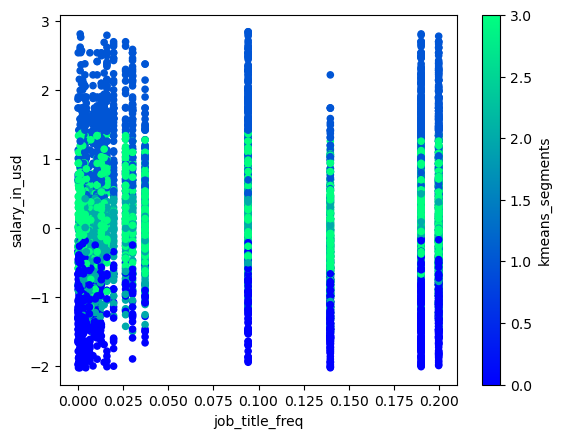

In [214]:
# Plot the clusters
salary_predictions_df.plot.scatter(
    x='job_title_freq',
    y='salary_in_usd',
    c='kmeans_segments',
    colormap='winter'
)

### Use Brich and AgglomerativeClustering to cluster data

In [215]:
# Fit a AgglomerativeClustering Model
agglo_model = AgglomerativeClustering(n_clusters=4)

# Make predictions with the AgglomerativeClustering model
agglo_predictions = agglo_model.fit_predict(cleaned_df)

# Save the agglo segments
salary_predictions_df['agglo_segments'] = agglo_predictions


In [216]:
# Fit a Brich Model with three clusters.
birch_model = Birch(n_clusters=4)
birch_model.fit(cleaned_df)

# Make predictions with the Birch model
birch_predictions = birch_model.predict(cleaned_df)

# Save the Birch segments
salary_predictions_df['brich_segments'] = birch_predictions

In [217]:
salary_predictions_df.head()

salary_in_usd  job_title_freq  employee_residence_freq  \
0       0.106333        0.199630                  0.80191   
1      -0.685809        0.199630                  0.80191   
2      -0.023039        0.189926                  0.80191   
3      -0.664610        0.189926                  0.80191   
4      -0.344258        0.006315                  0.80191   

   company_location_freq  experience_level_Executive-level  \
0               0.809304                                 0   
1               0.809304                                 0   
2               0.809304                                 0   
3               0.809304                                 0   
4               0.809304                                 0   

   experience_level_Mid-level  experience_level_Senior-level  \
0                           1                              0   
1                           1                              0   
2                           0                              1   
3                           0                              1   
4                           1                              0   

   employment_type_Freelance  employment_type_Full-time  \
0                          0                          1   
1                          0                          1   
2                          0                          1   
3                          0                          1   
4                          0                          1   

   employment_type_Part-time  work_models_On-site  work_models_Remote  \
0                          0                    0                   1   
1                          0                    0                   1   
2                          0                    0                   1   
3                          0                    0                   1   
4                          0                    1                   0   

   company_size_Medium  company_size_Small  kmeans_segments  agglo_segments  \
0                    1                   0                3               0   
1                    1                   0                0               0   
2                    1                   0                3               1   
3                    1                   0                3               1   
4                    1                   0                2               0   

   brich_segments  
0               0  
1               0  
2               0  
3               0  
4               2

<Axes: xlabel='job_title_freq', ylabel='salary_in_usd'>

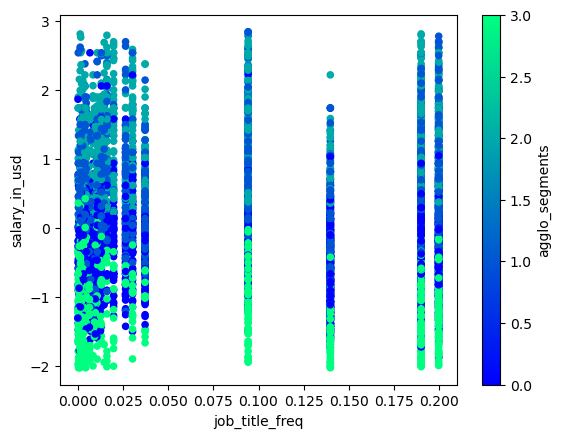

In [218]:
# Plot the AgglomerativeClustering clusters
salary_predictions_df.plot.scatter(
    x='job_title_freq',
    y='salary_in_usd',
    c='agglo_segments',
    colormap='winter'
)

<Axes: xlabel='job_title_freq', ylabel='salary_in_usd'>

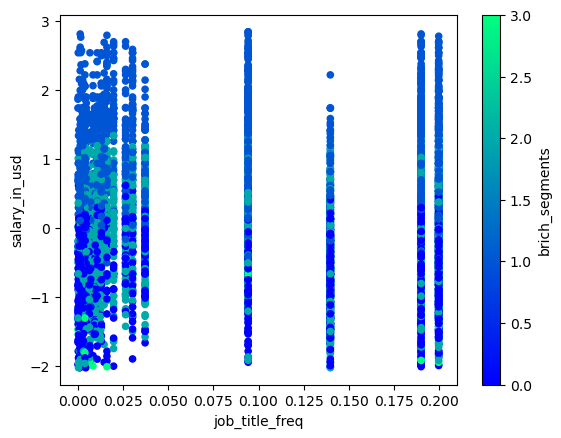

In [219]:
# Plot the Birch clusters
salary_predictions_df.plot.scatter(
    x='job_title_freq',
    y='salary_in_usd',
    c='brich_segments',
    colormap='winter'
)

## Optimize Clusters with Principal Component Analysis.

In [220]:
# Create a PCA model instance and set `n_components=3`.
pca = PCA(n_components=3)

# Use the PCA model with `fit_transform` on the original scaled DataFrame to reduce to three principal components.
scaled_data_pca = pca.fit_transform(cleaned_df)

# View the first five rows of the DataFrame. 
scaled_data_pca[0:5]

array([[-0.17992901, -0.65626058, -1.02419293],
       [-0.92107126, -0.60482609, -0.79016441],
       [ 0.07760565, -0.87061016,  0.34571242],
       [-0.52265957, -0.82895239,  0.53525658],
       [-0.47600782,  0.76095361, -0.714205  ]])

In [221]:
# Retrieve the explained variance to determine how much information  can be attributed to each principal component.
pca.explained_variance_ratio_

array([0.48484917, 0.20563969, 0.13802023])

In [222]:
# Create a new DataFrame with the PCA data.

# Creating a DataFrame with the PCA data
df_pca = pd.DataFrame(scaled_data_pca, columns=['PCA1', 'PCA2', 'PCA3'])

# Copy the crypto names from the original data
df_pca['index'] = cleaned_df.index

# Set the coinid column as index
df_pca = df_pca.set_index('index')

# Display sample data
df_pca.tail()

PCA1      PCA2      PCA3
index                              
6487  -1.817100 -0.103340  0.080910
6488  -2.088277  0.692723  0.308518
6489  -0.501417 -0.283443  0.441740
6490  -1.534734 -0.019127 -0.688447
6491  -0.844850  0.413851  0.643704

### Find the Best Value for k Using the PCA Data

In [223]:
# Create a a list to store inertia values and the values of k
inertia = []
k = list(range(1, 11))

# Create a for-loop where each value of k is evaluated using the K-means algorithm
# Fit the model using the service_ratings DataFrame
# Append the value of the computed inertia from the `inertia_` attribute of the KMeans model instance
for i in k:
    k_model = KMeans(n_clusters=i, n_init='auto', random_state=10)
    k_model.fit(df_pca)
    inertia.append(k_model.inertia_)

# Define a DataFrame to hold the values for k and the corresponding inertia
elbow_data = {'k' : k, 'inertia': inertia}
elbow_df = pd.DataFrame(elbow_data)

# Review the DataFrame
elbow_df

k       inertia
0   1  12235.945160
1   2   7544.864660
2   3   5748.109633
3   4   4479.098280
4   5   3484.633778
5   6   2894.592184
6   7   2529.604052
7   8   2114.601902
8   9   1749.805194
9  10   1595.859700

<Axes: title={'center': 'Elbow Curve'}, xlabel='k'>

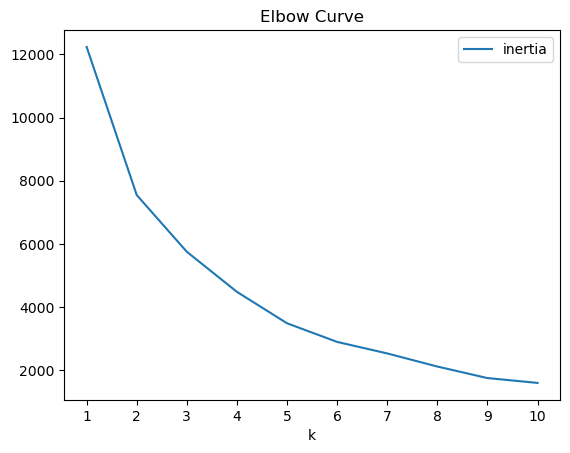

In [224]:
# Plot a line chart with all the inertia values computed with 
# the different values of k to visually identify the optimal value for k.
elbow_df.plot.line(x='k',
                   y='inertia',
                   title="Elbow Curve", 
                   xticks = k)

In [225]:
df_pca.head()

PCA1      PCA2      PCA3
index                              
0     -0.179929 -0.656261 -1.024193
1     -0.921071 -0.604826 -0.790164
2      0.077606 -0.870610  0.345712
3     -0.522660 -0.828952  0.535257
4     -0.476008  0.760954 -0.714205

In [226]:
# Initialize the K-Means model using the best value for k
k_model = KMeans(n_clusters=3, n_init='auto', random_state=10)

# Fit the K-Means model using the scaled data
k_model.fit(df_pca)

# Predict the clusters to group the cryptocurrencies using the scaled data
k_predictions = k_model.predict(df_pca)

# Create a copy of the preprocessed data
pca_predictions_df = df_pca.copy()

# Add a class column with the labels
pca_predictions_df['kmeans_segments'] = k_predictions

pca_predictions_df.head()

PCA1      PCA2      PCA3  kmeans_segments
index                                               
0     -0.179929 -0.656261 -1.024193                0
1     -0.921071 -0.604826 -0.790164                0
2      0.077606 -0.870610  0.345712                0
3     -0.522660 -0.828952  0.535257                0
4     -0.476008  0.760954 -0.714205                2

<Axes: xlabel='PCA1', ylabel='PCA2'>

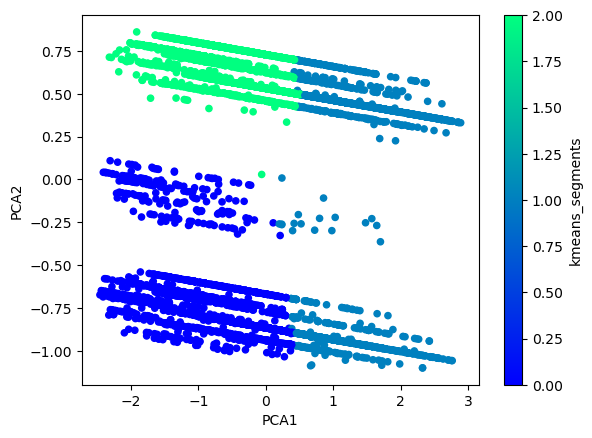

In [227]:
# Plot the clusters
pca_predictions_df.plot.scatter(
    x='PCA1',
    y='PCA2',
    c='kmeans_segments',
    colormap='winter'
)

### Use Brich and AgglomerativeClustering to cluster PCA data

In [228]:
# Fit a AgglomerativeClustering Model
agglo_model = AgglomerativeClustering(n_clusters=3)

# Make predictions with the AgglomerativeClustering model
agglo_predictions = agglo_model.fit_predict(df_pca)

# Save the agglo segments
pca_predictions_df['agglo_segments'] = agglo_predictions

In [229]:
# Fit a Birch Model
birch_model = Birch(n_clusters=3)
birch_model.fit(df_pca)

# Make predictions with the Birch model
birch_predictions = birch_model.predict(df_pca)

# Save the Birch segments
pca_predictions_df['brich_segments'] = birch_predictions


<Axes: xlabel='PCA1', ylabel='PCA2'>

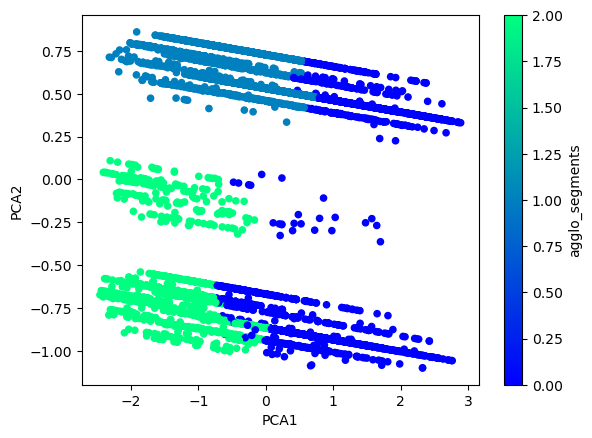

In [230]:
# Plot the AgglomerativeClustering clusters
pca_predictions_df.plot.scatter(
    x='PCA1',
    y='PCA2',
    c='agglo_segments',
    colormap='winter'
)

<Axes: xlabel='PCA1', ylabel='PCA2'>

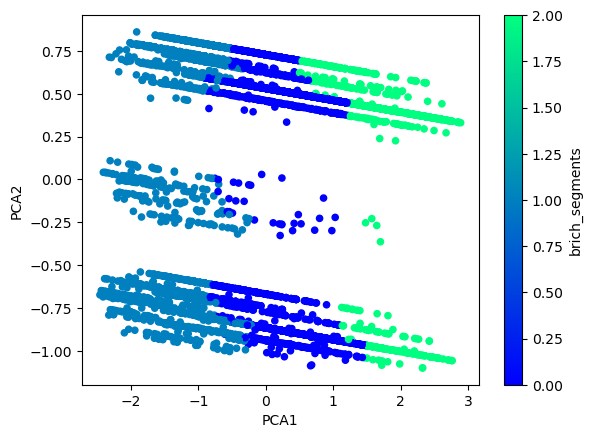

In [231]:
# Plot the Birch clusters
pca_predictions_df.plot.scatter(
    x='PCA1',
    y='PCA2',
    c='brich_segments',
    colormap='winter'
)

<Axes: xlabel='PCA1', ylabel='PCA3'>

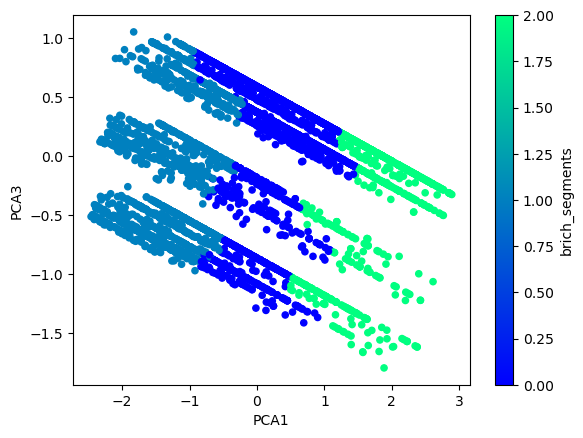

In [232]:
# Plot the Birch clusters
pca_predictions_df.plot.scatter(
    x='PCA1',
    y='PCA3',
    c='brich_segments',
    colormap='winter'
)

In [233]:
pca_component_weights = pd.DataFrame(pca.components_.T,
                                     columns=['PCA1', 'PCA2', 'PCA3'],
                                     index=cleaned_df.columns)
pca_component_weights

PCA1      PCA2      PCA3
salary_in_usd                     0.935618 -0.064931 -0.295438
job_title_freq                   -0.001362 -0.002141  0.000273
employee_residence_freq           0.136931  0.041885  0.031001
company_location_freq             0.131220  0.034394  0.027901
experience_level_Executive-level  0.016352 -0.005647 -0.060735
experience_level_Mid-level       -0.157513  0.111862 -0.632370
experience_level_Senior-level     0.221052 -0.110908  0.699317
employment_type_Freelance        -0.002826 -0.001408 -0.000289
employment_type_Full-time         0.009158  0.006136  0.004271
employment_type_Part-time        -0.003644 -0.001461 -0.000682
work_models_On-site               0.081979  0.697332  0.095126
work_models_Remote               -0.043260 -0.690211 -0.081793
company_size_Medium               0.072546  0.068741  0.049087
company_size_Small               -0.027327 -0.023793 -0.013616

In [234]:
stat_by_work_models = salary_df.groupby(['work_models'])['salary_in_usd'].agg(['mean', 'median', 'count'])
stat_by_experience_level = salary_df.groupby(['experience_level'])['salary_in_usd'].agg(['mean', 'median', 'count'])

print(stat_by_work_models)
print("")
print(stat_by_experience_level)

                      mean    median  count
work_models                                
Hybrid        79023.234234   65844.0    222
On-site      147385.916957  140130.0   3733
Remote       138226.495073  135000.0   2537

                           mean    median  count
experience_level                                
Entry-level        83978.081560   75000.0    564
Executive-level   179390.317992  180000.0    239
Mid-level         114548.110441  106200.0   1657
Senior-level      158326.205605  152000.0   4032


In [239]:
cleaned_df[['salary_in_usd', 'job_title_freq', 'employee_residence_freq', 'company_location_freq',
            'experience_level_Senior-level', 'work_models_On-site', 'employment_type_Full-time', 'company_size_Medium']].corr()

salary_in_usd  job_title_freq  \
salary_in_usd                       1.000000       -0.021796   
job_title_freq                     -0.021796        1.000000   
employee_residence_freq             0.384800        0.026637   
company_location_freq               0.370237        0.016695   
experience_level_Senior-level       0.346067        0.003490   
work_models_On-site                 0.110367       -0.015452   
employment_type_Full-time           0.100423        0.048003   
company_size_Medium                 0.187583        0.112919   

                               employee_residence_freq  company_location_freq  \
salary_in_usd                                 0.384800               0.370237   
job_title_freq                                0.026637               0.016695   
employee_residence_freq                       1.000000               0.969093   
company_location_freq                         0.969093               1.000000   
experience_level_Senior-level                 0.205974               0.194440   
work_models_On-site                           0.167223               0.148801   
employment_type_Full-time                     0.116506               0.075995   
company_size_Medium                           0.281230               0.256374   

                               experience_level_Senior-level  \
salary_in_usd                                       0.346067   
job_title_freq                                      0.003490   
employee_residence_freq                             0.205974   
company_location_freq                               0.194440   
experience_level_Senior-level                       1.000000   
work_models_On-site                                 0.021542   
employment_type_Full-time                           0.080170   
company_size_Medium                                 0.156592   

                               work_models_On-site  employment_type_Full-time  \
salary_in_usd                             0.110367                   0.100423   
job_title_freq                           -0.015452                   0.048003   
employee_residence_freq                   0.167223                   0.116506   
company_location_freq                     0.148801                   0.075995   
experience_level_Senior-level             0.021542                   0.080170   
work_models_On-site                       1.000000                   0.078402   
employment_type_Full-time                 0.078402                   1.000000   
company_size_Medium                       0.210504                   0.141067   

                               company_size_Medium  
salary_in_usd                             0.187583  
job_title_freq                            0.112919  
employee_residence_freq                   0.281230  
company_location_freq                     0.256374  
experience_level_Senior-level             0.156592  
work_models_On-site                       0.210504  
employment_type_Full-time                 0.141067  
company_size_Medium                       1.000000

# Output preprocessed data before scalling salary_in_usd

In [251]:
display(encoded_df)

salary_in_usd  job_title_freq  employee_residence_freq  \
0            148100        0.199630                 0.801910   
1             98700        0.199630                 0.801910   
2            140032        0.189926                 0.801910   
3            100022        0.189926                 0.801910   
4            120000        0.006315                 0.801910   
...             ...             ...                      ...   
6487          44753        0.000462                 0.037123   
6488          15000        0.000462                 0.001848   
6489         117104        0.000616                 0.037123   
6490          74130        0.199630                 0.000924   
6491          91237        0.189926                 0.000924   

      company_location_freq  experience_level_Executive-level  \
0                  0.809304                                 0   
1                  0.809304                                 0   
2                  0.809304                                 0   
3                  0.809304                                 0   
4                  0.809304                                 0   
...                     ...                               ...   
6487               0.037431                                 0   
6488               0.037431                                 1   
6489               0.037431                                 0   
6490               0.000924                                 0   
6491               0.000924                                 0   

      experience_level_Mid-level  experience_level_Senior-level  \
0                              1                              0   
1                              1                              0   
2                              0                              1   
3                              0                              1   
4                              1                              0   
...                          ...                            ...   
6487                           0                              0   
6488                           0                              0   
6489                           0                              1   
6490                           1                              0   
6491                           0                              1   

      employment_type_Freelance  employment_type_Full-time  \
0                             0                          1   
1                             0                          1   
2                             0                          1   
3                             0                          1   
4                             0                          1   
...                         ...                        ...   
6487                          0                          0   
6488                          0                          1   
6489                          0                          1   
6490                          0                          1   
6491                          0                          1   

      employment_type_Part-time  work_models_On-site  work_models_Remote  \
0                             0                    0                   1   
1                             0                    0                   1   
2                             0                    0                   1   
3                             0                    0                   1   
4                             0                    1                   0   
...                         ...                  ...                 ...   
6487                          0                    0                   0   
6488                          0                    1                   0   
6489                          0                    0                   0   
6490                          0                    0                   0   
6491                          0                    1                  

In [ ]:
# Export to CSV
# encoded_df.to_csv("resources/data_science_salaries_encoded.csv", index=False)


# out_file_location = "./resources/data_science_salaries_encoded.csv"
# out_file_path = Path(out_file_location)

# out_salary_df = pd.read_csv(out_file_path)
# # Display the DataFrame:
# out_salary_df.tail()